# 1. Building an SIRH IPM with epymorph

Using epymorph's model definition features, we can construct an SIRH model with suitable parameters.

![SIRH model diagram](img/SIRH-diagram.png)

The differential equations for this model are as follows:

$$
\begin{aligned}
& \frac{dS}{dt} = -\frac{\beta S I}{N} + \xi R \\
& \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
& \frac{dR}{dt} = (1 - h_p) \gamma I + \frac{H}{h_d} - \xi R \\
& \frac{dH}{dt} = h_p \gamma I - \frac{H}{h_d}
\end{aligned}
$$

Where $h_p$ and $h_d$ describes the probability of and expected duration of hospitalization, respectively.

In [1]:
from sympy import Max

from epymorph import *
from epymorph.compartment_model import *


def construct_ipm():
    symbols = create_symbols(
        compartments=[
            compartment('S'),
            compartment('I'),
            compartment('R'),
            compartment('H', tags=['immobile'])
        ],
        attributes=[
            param('beta', shape=Shapes.TxN),
            param('gamma', shape=Shapes.TxN),
            param('xi', shape=Shapes.TxN),
            param('hospitalization_prob', shape=Shapes.TxN),
            param('hospitalization_duration', shape=Shapes.TxN)
        ])

    [S, I, R, H] = symbols.compartment_symbols
    [β, γ, ξ, h_prob, h_dur] = symbols.attribute_symbols

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    N = Max(1, S + I + R + H)

    return create_model(
        symbols=symbols,
        transitions=[
            edge(S, I, rate=β * S * I / N),
            fork(
                edge(I, H, rate=γ * I * h_prob),
                edge(I, R, rate=γ * I * (1 - h_prob)),
            ),
            edge(H, R, rate=H / h_dur),
            edge(R, S, rate=ξ * R),
        ]
    )


sirh_ipm = construct_ipm()

Having built the IPM, we can now use it as the basis of a simple simulation.

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.035s


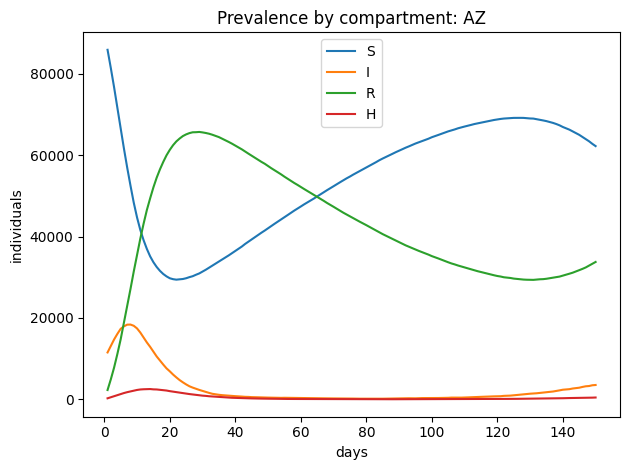

In [2]:
from functools import partial

from epymorph.initializer import single_location

sim = StandardSimulation(
    geo=geo_library['single_pop'](),
    ipm=sirh_ipm,
    mm=mm_library['no'](),
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    initializer=partial(single_location, location=0, seed_size=10_000)
)

with sim_messaging(sim):
    output = sim.run()

plot_pop(output, pop_idx=0)